In [27]:
import numpy as np
import pandas as pd
import numpy as np
import os
import sys
import librosa.display
import matplotlib.pyplot as plt
from IPython.display import Audio
import wave
from scipy.io.wavfile import write
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
#import tensorflow as tf
#from tf.keras.models import Sequential
#from keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, BatchNormalization
#from keras.utils import np_utils, to_categorical
#from keras.callbacks import ModelCheckpoint


In [39]:
data = pd.read_csv("../speech_emotion_reco/data/merged_dataset.csv")

In [29]:
data.head()

,Unnamed: 0,gender,emotion,path,duration
0,0,male,sad,../speech_emotion_reco/data/savee/JK_sa01.wav,4.511837
1,1,male,sad,../speech_emotion_reco/data/savee/JK_sa15.wav,6.058730
2,2,male,neutral,../speech_emotion_reco/data/savee/DC_n13.wav,2.788889
3,3,male,surprise,../speech_emotion_reco/data/savee/DC_su09.wav,3.433968
4,4,male,neutral,../speech_emotion_reco/data/savee/DC_n07.wav,4.051791


In [6]:
data["emotion"].value_counts()

happy       1924
sad         1923
fear        1923
disgust     1923
angry       1923
neutral     1895
surprise     452
unknown      200
Name: emotion, dtype: int64

In [27]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for audio with {} emotion'.format(e), size=15)
    librosa.display.waveplot(data, sr=sr)
    plt.show()

In [28]:
def create_spectrogram(data, sr, e):
    # stft function converts the data into short term fourier transform
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for audio with {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    #librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar()

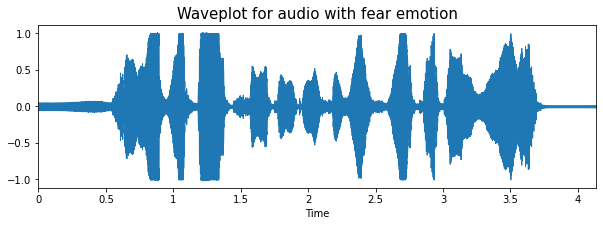

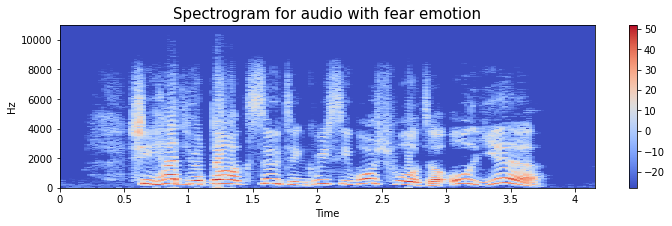

In [22]:
emotion='fear'
path = np.array(data["path"][data["emotion"]==emotion])[1]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [29]:
data

,Unnamed: 0,gender,emotion,path,duration
0,0,male,sad,../speech_emotion_reco/data/savee/JK_sa01.wav,4.511837
1,1,male,sad,../speech_emotion_reco/data/savee/JK_sa15.wav,6.058730
2,2,male,neutral,../speech_emotion_reco/data/savee/DC_n13.wav,2.788889
3,3,male,surprise,../speech_emotion_reco/data/savee/DC_su09.wav,3.433968
4,4,male,neutral,../speech_emotion_reco/data/savee/DC_n07.wav,4.051791
...,...,...,...,...,...
12158,12158,female,angry,../speech_emotion_reco/data/crema/1089_WSI_ANG...,2.268980
12159,12159,female,angry,../speech_emotion_reco/data/crema/1025_IWW_ANG...,2.002041
12160,12160,female,angry,../speech_emotion_reco/data/crema/1030_IWW_ANG...,2.369025
12161,12161,male,angry,../speech_emotion_reco/data/crema/1019_TIE_ANG...,3.303356


In [30]:
def noise(data):
    noise_amp = 0.035*np.random.uniform()*np.amax(data)
    data = data + noise_amp*np.random.normal(size=data.shape[0])
    return data

def stretch(data, rate=0.8):
    return librosa.effects.time_stretch(data, rate)

def shift(data):
    shift_range = int(np.random.uniform(low=-5, high = 5)*1000)
    return np.roll(data, shift_range)

def pitch(data, sampling_rate, pitch_factor=0.7):
    return librosa.effects.pitch_shift(data, sampling_rate, pitch_factor)

# taking any example and checking for techniques.
path = np.array(data["path"])[1]
data, sample_rate = librosa.load(path)

In [40]:
len(data)

12163

In [41]:
def extract_features(data):
    # ZCR
    result = np.array([])
    zcr = np.mean(librosa.feature.zero_crossing_rate(y=data).T, axis=0)
    result=np.hstack((result, zcr)) # stacking horizontally

    # Chroma_stft
    stft = np.abs(librosa.stft(data))
    chroma_stft = np.mean(librosa.feature.chroma_stft(S=stft, sr=sample_rate).T, axis=0)
    result = np.hstack((result, chroma_stft)) # stacking horizontally

    # MFCC
    mfcc = np.mean(librosa.feature.mfcc(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mfcc)) # stacking horizontally
    
    # Root Mean Square Value
    rms = np.mean(librosa.feature.rms(y=data).T, axis=0)
    result = np.hstack((result, rms)) # stacking horizontally

    # MelSpectogram
    mel = np.mean(librosa.feature.melspectrogram(y=data, sr=sample_rate).T, axis=0)
    result = np.hstack((result, mel)) # stacking horizontally
    
    return result

In [42]:
def get_features(path):
    # duration and offset are used to take care of the no audio in start and the ending of each audio files as seen above.
    data, sample_rate = librosa.load(path, duration=2.5, offset=0.6)
    
    # without augmentation
    res1 = extract_features(data)
    result = np.array(res1)
    
    # data with noise
    noise_data = noise(data)
    res2 = extract_features(noise_data)
    result = np.vstack((result, res2)) # stacking vertically
    
    # data with stretching and pitching
    new_data = stretch(data)
    data_stretch_pitch = pitch(new_data, sample_rate)
    res3 = extract_features(data_stretch_pitch)
    result = np.vstack((result, res3)) # stacking vertically
    
    return result

In [73]:
data_sample = data[0:100]

In [74]:
data_sample

,Unnamed: 0,gender,emotion,path,duration
0,0,male,sad,../speech_emotion_reco/data/savee/JK_sa01.wav,4.511837
1,1,male,sad,../speech_emotion_reco/data/savee/JK_sa15.wav,6.058730
2,2,male,neutral,../speech_emotion_reco/data/savee/DC_n13.wav,2.788889
3,3,male,surprise,../speech_emotion_reco/data/savee/DC_su09.wav,3.433968
4,4,male,neutral,../speech_emotion_reco/data/savee/DC_n07.wav,4.051791
...,...,...,...,...,...
95,95,male,disgust,../speech_emotion_reco/data/savee/JK_d07.wav,3.039864
96,96,male,sad,../speech_emotion_reco/data/savee/KL_sa03.wav,1.766395
97,97,male,disgust,../speech_emotion_reco/data/savee/JK_d13.wav,5.503175
98,98,male,disgust,../speech_emotion_reco/data/savee/DC_d08.wav,4.402540


In [98]:
X, Y = [], []
for path, emotion in zip(data["path"], data["emotion"]):
    feature = get_features(path)
    for ele in feature:
        X.append(ele)
        # appending emotion 3 times as we have made 3 augmentation techniques on each audio file.
        Y.append(emotion)

/Users/arthurcaron/.pyenv/versions/3.8.6/lib/python3.8/site-packages/librosa/core/pitch.py:153: UserWarning: Trying to estimate tuning from empty frequency set.
  warnings.warn("Trying to estimate tuning from empty frequency set.")


In [99]:
pd.DataFrame(X)

,0,1,2,3,4,5,6,7,8,9,...,152,153,154,155,156,157,158,159,160,161
0,0.022190,0.574264,0.483570,0.460849,0.481322,0.555484,0.593383,0.527021,0.487356,0.539324,...,4.877737e-05,1.731863e-05,5.487893e-06,1.681743e-06,1.302462e-06,1.284306e-06,1.304934e-06,1.355323e-06,1.416036e-06,1.307451e-06
1,0.022814,0.592123,0.546146,0.491090,0.500185,0.551924,0.615589,0.561349,0.497531,0.522059,...,2.457960e-04,2.099711e-04,2.212088e-04,2.117747e-04,2.059976e-04,2.064059e-04,2.126684e-04,2.049085e-04,1.968838e-04,2.094761e-04
2,0.025253,0.492150,0.549739,0.484813,0.479530,0.517128,0.570642,0.615433,0.521987,0.452409,...,6.568638e-05,2.646881e-05,7.267621e-06,3.030797e-06,1.611535e-06,1.207506e-06,1.187589e-06,1.176784e-06,1.092254e-06,9.574061e-07
3,0.018410,0.635455,0.514304,0.476947,0.516035,0.538225,0.572309,0.577087,0.545820,0.521525,...,5.941954e-06,1.704343e-06,4.997833e-07,2.244980e-07,2.392561e-07,2.810812e-07,3.590882e-07,5.512045e-07,8.656837e-07,1.010199e-06
4,0.029179,0.702898,0.617161,0.594481,0.631746,0.640855,0.651384,0.612003,0.575928,0.557582,...,4.706841e-03,4.890463e-03,4.899112e-03,4.909364e-03,5.054977e-03,5.002242e-03,4.940670e-03,4.868342e-03,5.149540e-03,5.300041e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36484,0.305343,0.685967,0.742892,0.779671,0.833089,0.840275,0.701539,0.659502,0.742180,0.778934,...,2.539647e-02,2.478279e-02,2.420719e-02,2.342870e-02,2.504317e-02,2.612669e-02,2.409720e-02,2.356624e-02,2.517903e-02,2.573779e-02
36485,0.102018,0.452893,0.520814,0.600315,0.639890,0.675275,0.568764,0.536117,0.640488,0.706558,...,2.973360e-09,1.425885e-09,1.464163e-09,1.411418e-09,1.297916e-09,1.348296e-09,1.437629e-09,1.703382e-09,2.167032e-09,2.448878e-09
36486,0.056389,0.564846,0.579820,0.541094,0.558098,0.645200,0.613288,0.619439,0.686727,0.766889,...,5.406271e-10,5.040548e-10,4.780014e-10,4.583831e-10,4.421976e-10,4.287349e-10,4.179993e-10,4.094248e-10,4.034485e-10,3.995670e-10
36487,0.212662,0.711138,0.712789,0.731678,0.828421,0.835625,0.717806,0.704654,0.749505,0.840525,...,9.773441e-04,9.843404e-04,1.003264e-03,9.815491e-04,1.015862e-03,1.026426e-03,1.032031e-03,9.910294e-04,9.583302e-04,9.978714e-04


In [100]:
pd.DataFrame(Y)[0].value_counts()

happy       5772
sad         5769
fear        5769
disgust     5769
angry       5769
neutral     5685
surprise    1356
unknown      600
Name: 0, dtype: int64

In [101]:
Features = pd.DataFrame(X)
Features['labels'] = Y
Features.to_csv('features.csv', index=False)
Features.head()

,0,1,2,3,4,5,6,7,8,9,...,153,154,155,156,157,158,159,160,161,labels
0,0.022190,0.574264,0.483570,0.460849,0.481322,0.555484,0.593383,0.527021,0.487356,0.539324,...,0.000017,5.487893e-06,1.681743e-06,1.302462e-06,1.284306e-06,1.304934e-06,1.355323e-06,1.416036e-06,1.307451e-06,sad
1,0.022814,0.592123,0.546146,0.491090,0.500185,0.551924,0.615589,0.561349,0.497531,0.522059,...,0.000210,2.212088e-04,2.117747e-04,2.059976e-04,2.064059e-04,2.126684e-04,2.049085e-04,1.968838e-04,2.094761e-04,sad
2,0.025253,0.492150,0.549739,0.484813,0.479530,0.517128,0.570642,0.615433,0.521987,0.452409,...,0.000026,7.267621e-06,3.030797e-06,1.611535e-06,1.207506e-06,1.187589e-06,1.176784e-06,1.092254e-06,9.574061e-07,sad
3,0.018410,0.635455,0.514304,0.476947,0.516035,0.538225,0.572309,0.577087,0.545820,0.521525,...,0.000002,4.997833e-07,2.244980e-07,2.392561e-07,2.810812e-07,3.590882e-07,5.512045e-07,8.656837e-07,1.010199e-06,sad
4,0.029179,0.702898,0.617161,0.594481,0.631746,0.640855,0.651384,0.612003,0.575928,0.557582,...,0.004890,4.899112e-03,4.909364e-03,5.054977e-03,5.002242e-03,4.940670e-03,4.868342e-03,5.149540e-03,5.300041e-03,sad


In [102]:
X = Features.iloc[: ,:-1].values
Y = Features['labels'].values

In [103]:
# As this is a multiclass classification problem onehotencoding our Y.
encoder = OneHotEncoder()
Y = encoder.fit_transform(np.array(Y).reshape(-1,1)).toarray()

In [104]:
# splitting data
x_train, x_test, y_train, y_test = train_test_split(X, Y, random_state=0, shuffle=True)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27366, 162), (27366, 8), (9123, 162), (9123, 8))

In [105]:
# scaling our data with sklearn's Standard scaler
scaler = StandardScaler()
x_train = scaler.fit_transform(x_train)
x_test = scaler.transform(x_test)
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((27366, 162), (27366, 8), (9123, 162), (9123, 8))

In [106]:
# making our data compatible to model.
#x_train = np.expand_dims(x_train, axis=2)
#x_test = np.expand_dims(x_test, axis=2)
#x_train.shape, y_train.shape, x_test.shape, y_test.shape

In [107]:
x_train

array([[ 1.78867448,  1.5145362 ,  1.44875584, ..., -0.17566308,
        -0.1617455 , -0.15360386],
       [-1.27257576,  0.37301025, -0.65820539, ..., -0.22554736,
        -0.21287732, -0.20400592],
       [ 2.07835725,  0.61000927,  0.2370615 , ..., -0.2122487 ,
        -0.20791637, -0.20245501],
       ...,
       [ 0.27679   ,  0.25155924,  0.44317351, ..., -0.18887466,
        -0.17612799, -0.16585193],
       [-0.51122219,  0.54016688,  0.63991329, ..., -0.22563789,
        -0.21301984, -0.20417274],
       [-0.01761639,  0.90060402,  0.54478415, ..., -0.22556401,
        -0.21299148, -0.20417192]])

In [113]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

model = RandomForestClassifier()

cv = cross_validate(model, x_train, y_train, cv = 5)

In [109]:
y_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]])

In [114]:
cv["test_score"].mean()

0.32427127398119615